In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import csv , warnings
from Cosine_Power_Model import model_fit , model_param , I_calc_cos2 , RMSE

In [2]:
datasheet = 'Nichia.csv'
file = csv.reader(open(datasheet))  #read in relevant datasheet
angle = np.linspace(-90 , 90 , 181*50)
theta = angle*np.pi/180
data = []
x_axis = []
x_axis_rad = []
y_axis = []
Power = []

for row in file:
    data.append([float(row[0]),float(row[1])])

data.sort(key = lambda x: x[0])  #sorts the array in ascending order

for item in data :
    x_axis_rad.append(item[0]*np.pi/180) #converts to radians
    x_axis.append(item[0])
    y_axis.append(item[1])
    
    
"Specifying the boundary will affect the accuracy of the model."
"It is easiest to start with a relatively low accuracy and refine the boundary accoringly"
bound = [[.1 , [1 , 1] , [0 ,0] , [0 , 10]] , [.02,[0,.2] , [45 , 90] , [0 , 200]] , [.02, [0 , 0.2] , [0 ,45] , [0 , 200]] , [.015,[0 , 0.2] , [0 ,90] , [0 , 200]]]

Power , Error , Param = model_fit(x_axis , y_axis , .017 , bound)

RMSE: 0.050641298624668915
R-squared: 0.981117696041258

RMSE: 0.019073100008894953
R-squared: 0.9972776809885643

RMSE: 0.019073100008894953
R-squared: 0.9972776809885643

RMSE: 0.01536714308676109
R-squared: 0.9980652526620926



Model Variables
	   c1 		   c2 		   c3
1. 	 1.000e+00 	 0.000e+00 	 7.778e+00 
2. 	 1.333e-01 	 5.000e+01 	 2.222e+01 
3. 	 0.000e+00 	 0.000e+00 	 0.000e+00 
4. 	 2.222e-02 	 2.000e+01 	 2.222e+01 


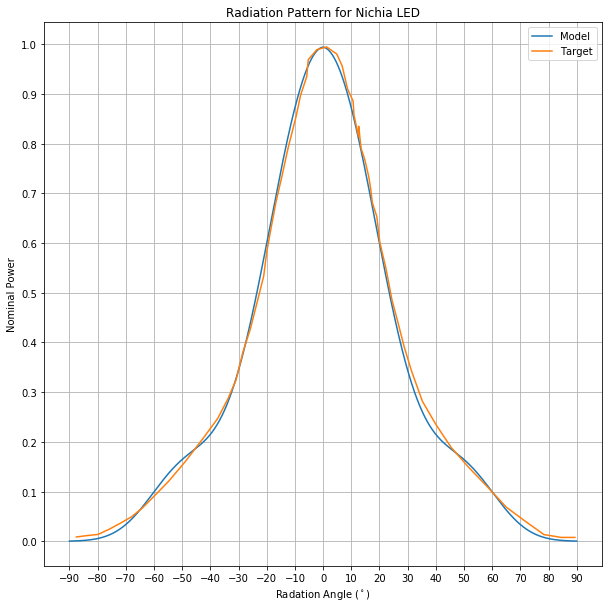

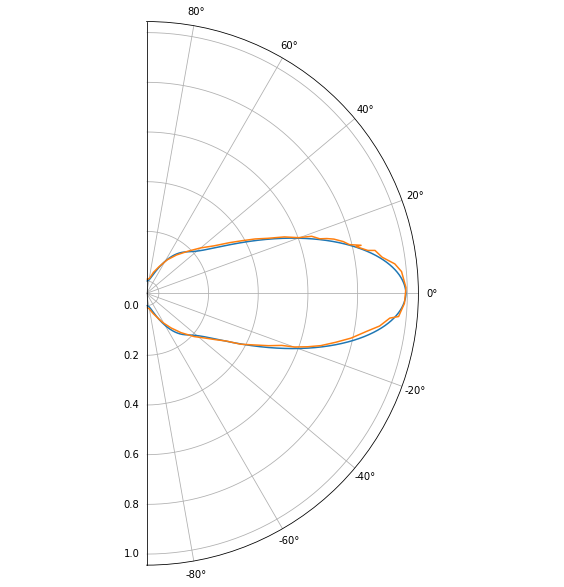

In [3]:
c1 , c2 ,c3 = model_param(Param)
ModelPrediction = I_calc_cos2(theta , c1 , c2 , c3 )

print("Model Variables")
print("\t   c1 \t\t   c2 \t\t   c3")
for i in range(len(c1)) :
    print("%i. \t %1.3e \t %1.3e \t %1.3e " % (i+1 , c1[i] , c2[i] , c3[i]))
    
plt.figure(figsize= (10,10))
plt.plot(angle , ModelPrediction , label = "Model")
plt.plot(x_axis , y_axis , label = "Target")
plt.xticks(np.arange(-90 , 100 , step = 10))
plt.yticks(np.arange(0,1.1 , step = 0.1))
plt.title("Radiation Pattern for %s LED" % datasheet[:-4])
plt.xlabel("Radation Angle $(^\circ)$")
plt.ylabel("Nominal Power")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize= (20 ,10 ))
plt.polar(theta , ModelPrediction)
plt.polar(x_axis_rad , y_axis)
plt.xlim(-np.pi/2 , np.pi/2)
plt.show()

Enter Distance from Source : 0.1


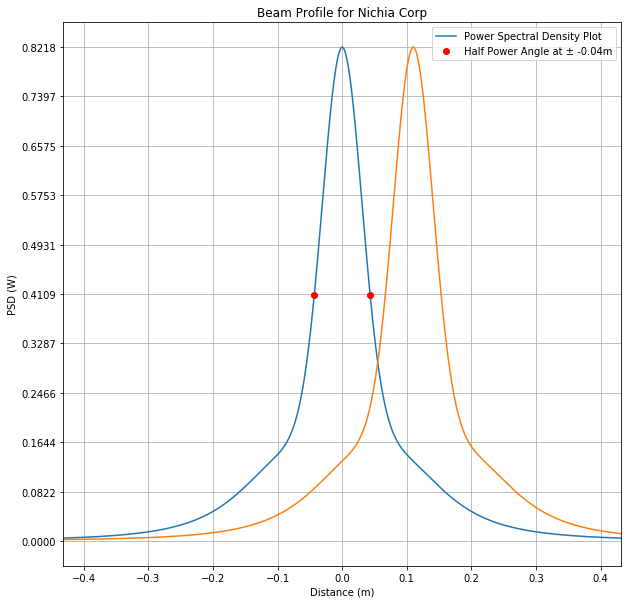

In [282]:
select_dis = float(input("Enter Distance from Source : "))
seperation = .11
d = []
dis = []
dis2 = []
for item in theta :
    dis2.append(seperation + (select_dis*np.tan(item)))
    dis.append(select_dis*np.tan(item))
    a = select_dis*((1/np.cos(item))-1)
    d.append(1 + a + select_dis)

PSD_dis = []
for i in range(len(ModelPrediction)) :
    PSD_dis.append(ModelPrediction[i]/(d[i]**2))

dis_50 = []
Power_50 = []
PSD_50 = max(PSD_dis)/2
limit = max(PSD_dis)/500
for i in range(len(PSD_dis)) :  
    if PSD_50 - limit <= PSD_dis[i] <= PSD_50 + limit :
        dis_50.append(dis[i])
        Power_50.append(PSD_dis[i])
        

fig = plt.figure(figsize = (10,10))
plt.plot(dis,PSD_dis , label = "Power Spectral Density Plot")
plt.plot(dis2, PSD_dis)
plt.plot(dis_50[0], Power_50[0] , 'ro' , label = 'Half Power Angle at \u00B1 %1.2fm' %dis_50[1])
plt.plot(dis_50[-1], Power_50[-1] , 'ro')
plt.grid()
plt.title("Beam Profile for Nichia Corp")
plt.xlabel("Distance (m)")
plt.ylabel("PSD (W)")
#plt.xlim(-1,1)
plt.xlim(10*dis_50[0] , 10*dis_50[-1])
plt.yticks(np.arange(0,max(PSD_dis)+max(PSD_dis)/10 , step = max(PSD_dis)/10))
plt.legend()
plt.show()

In [177]:
def origin_adjustment(origin , source_dis) :
    angle = np.linspace(-90 , 90 , 181*10)
    theta = angle*np.pi/180
    dis = []
    d = []

    for item in theta :
        dis.append(origin + (np.tan(item)))
        
    theta2 = []
    for item in dis :
        theta2.append(np.arctan(item))
        
    for item in theta2 :
        d.append(1 + source_dis/np.cos(item))
        
    Beam_Profile = I_calc_cos2(theta2 , c1 , c2 ,c3)
        
    PSD_dis = []
    for i in range(len(Beam_Profile)) :
        PSD_dis.append(Beam_Profile[i]/(d[i]**2))    
        
    return PSD_dis

In [178]:
def beam_optomization(origin , source_dis , model) :
    model_temp1  = origin_adjustment(origin , source_dis)

    model_final = []
    if len(model) > 0:
        for item1 , item2 in zip(model_temp1 , model) :
            model_final.append(item1 + item2)
    else :
        model_final = model_temp1
    
    return model_final 

In [179]:
def LSE(model , target , origin , source_dis , count) :
    LSE = []
    for item1 in origin :
        for item2 in source_dis:            
            model_temp  = beam_optomization(item1 , item2 , model)           
            if max(model_temp[count : -count]) > max(target[count : -count]) :
                pass
            else :
                SQE = np.sum((np.array(model_temp[count : -count]) - np.array(target[count : -count])) ** 2.0)
                LSE.append([SQE , item1 , item2])
    
    return min(LSE)

In [134]:
def LSE(model , target , count) :
    LSE = []
    origin1 = np.linspace(0 , 0.3 , 11)
    origin2 = np.linspace(0.3 , 1.2 , 11)
    source_dis1 = np.linspace(min_dis , min_dis + 0.3 , 11)
    source_dis2 = np.linspace(min_dis , min_dis + 1.3 , 11)
    for item1 , item3 in zip(origin1 , origin2) :
        for item2 , item4 in zip(source_dis1 , source_dis2):            
            model_LED1  = beam_optomization(item1 , item2 , model)
            model_temp = beam_optomization(item3 , item4 , model_LED1)
            if max(model_temp[count : -count]) > max(target[count : -count]) :
                pass
            else :
                SQE = np.sum((np.array(model_temp[count : -count]) - np.array(target[count : -count])) ** 2.0)
                LSE.append([SQE , item1 , item2 , item3 , item4])
    
    return min(LSE)

RMSE: 0.13340494900496525
R-squared: -inf

0.2 0.4102633808323559


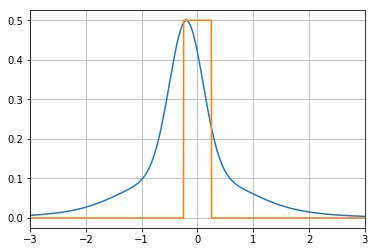

ValueError: min() arg is an empty sequence

In [181]:
start = time.time()
angle = np.linspace(-90 , 90 , 181*10)
theta = angle*np.pi/180
x_axis = []

for item in theta :
    x_axis.append(np.tan(item))

target = []
count = 0
for item in x_axis :
    if -.25 <= item <= .25 :
        target.append(0.5)
    else :
        target.append(0)
        count = count + 1
        
count = int(count/2)
        
min_dis = np.sqrt(max(ModelPrediction)/(max(target))) - 1
output = []
origin = np.linspace(0.2 , 0.4 , 11)
source_dis = np.linspace(min_dis , min_dis + 0.3 , 21)

for i in range(2) :
    param = LSE(output , target , origin , source_dis , count)
    output = beam_optomization(param[1] , param[2] , output)
    absError = np.array(target) - np.array(output)
    RMSE(absError[count : -count] , target[count : -count])
    print(param[1] , param[2])
    plt.plot(x_axis , output)
    plt.plot(x_axis , target)
    plt.xlim(-3,3)
    plt.grid()
    plt.show()
    
end = time.time()
print(end - start)

(-2, 2)

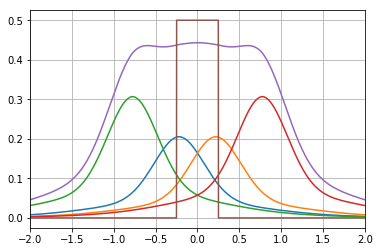

In [173]:
output1 = origin_adjustment(0.22 , 1.2)
output2 = origin_adjustment(-1*0.22 , 1.2)
output3 = origin_adjustment(.775, .8)
output4 = origin_adjustment(-1*.775 , .8)

output5 = []
for item1 , item2 ,item3 , item4 in zip(output1 , output2 ,output3 , output4) :
    output5.append(item1 + item2 + item3 + item4 )
    
plt.plot(x_axis , output1)
plt.plot(x_axis , output2)
plt.plot(x_axis , output3)
plt.plot(x_axis , output4)
plt.grid()
plt.plot(x_axis , output5)
plt.plot(x_axis , target)
plt.xlim(-2,2)